In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import numpy as np
import pickle
sys.path.append('D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin')
from models import *
from clients_datasets import *
from tqdm.notebook import tqdm
from utils import *
from AttFunc import *
from Fisher_LeNet import *

In [7]:
batch_size = 600
epochs = 10
NC = 10
dataset = 'mnist'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 4

criterion = torch.nn.CrossEntropyLoss()

In [8]:
losses = []  # 用于存放每个全局轮次的loss
test_accuracies = []  # 用于存放每个全局轮次的测试准确率
#################################################################################
###########################   Normal training   #################################
# train
server.apply(init_weights)
clients[0].apply(init_weights)
last_trained_params = clients[0].state_dict()
for epoch in tqdm(range(epochs), desc="Normal Training", unit="epoch"):
    epoch_loss = 0.0
    server.train()
    for i in range(NC):
        clients[i].train()
    for idx, client in enumerate(clients):
        client.load_state_dict(last_trained_params)
        for j, data in enumerate(clients_trainloader[idx]):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            smashed_data = client.forward(images, client_level=client_level)
            output = server.forward(smashed_data, server_level=server_level)
            clients_opts[idx].zero_grad()
            server_opt.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            clients_opts[idx].step()
            server_opt.step()
            epoch_loss += loss.item()  # 累加每个batch的loss
        last_trained_params = client.state_dict()
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)
    # 计算并保存每个全局轮次的平均loss
    average_loss = epoch_loss / len(clients)
    losses.append(average_loss)

    # 测试并保存每个全局轮次的准确率
    server.eval()
    clients_acc0 = []
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc0 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc0 = 100 * correct / total
            clients_acc0.append(acc0)
    test_accuracies.append(np.mean(clients_acc0))

    # 将全局轮次的loss和测试结果输出
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {np.mean(clients_acc0):.2f}%')

# 最终保存loss和准确率数组
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss1.npy', losses)
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc1.npy', test_accuracies)


Normal Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch [1/10], Loss: 8.0755, Accuracy: 92.68%
Epoch [2/10], Loss: 1.8664, Accuracy: 96.28%
Epoch [3/10], Loss: 1.1619, Accuracy: 97.34%
Epoch [4/10], Loss: 0.9291, Accuracy: 97.40%
Epoch [5/10], Loss: 0.7839, Accuracy: 97.79%
Epoch [6/10], Loss: 0.6559, Accuracy: 98.01%
Epoch [7/10], Loss: 0.5755, Accuracy: 97.99%
Epoch [8/10], Loss: 0.5245, Accuracy: 98.34%
Epoch [9/10], Loss: 0.4698, Accuracy: 98.38%
Epoch [10/10], Loss: 0.4317, Accuracy: 98.59%


In [9]:
batch_size = 600
epochs = 10
NC = 10
dataset = 'mnist'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 4

criterion = torch.nn.CrossEntropyLoss()

In [10]:
losses = []
test_accuracies = []
#################################################################################
###########################   Normal training   #################################
# train
server.train()
for i in range(NC):
    clients[i].train()
for epoch in tqdm(range(epochs), desc="Normal Training", unit="epoch"):
    epoch_loss = 0.0
    for idx, client in enumerate(clients):
        for j, data in enumerate(clients_trainloader[idx]):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            smashed_data = client.forward(images, client_level=client_level)
            output = server.forward(smashed_data, server_level=server_level)
            clients_opts[idx].zero_grad()
            server_opt.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            clients_opts[idx].step()
            server_opt.step()
            epoch_loss += loss.item()  # 累加每个batch的loss
    # 计算并保存每个全局轮次的平均loss
    average_loss = epoch_loss / len(clients)
    losses.append(average_loss)
    # 测试并保存每个全局轮次的准确率
    server.eval()
    clients_acc0 = []
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc0 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc0 = 100 * correct / total
            clients_acc0.append(acc0)
    test_accuracies.append(np.mean(clients_acc0))
    # 将全局轮次的loss和测试结果输出
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {np.mean(clients_acc0):.2f}%')

# 最终保存loss和准确率数组
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss2.npy', losses)
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc2.npy', test_accuracies)

Normal Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch [1/10], Loss: 17.0110, Accuracy: 58.18%
Epoch [2/10], Loss: 8.1763, Accuracy: 74.08%
Epoch [3/10], Loss: 5.5564, Accuracy: 82.67%
Epoch [4/10], Loss: 4.2849, Accuracy: 85.39%
Epoch [5/10], Loss: 3.8117, Accuracy: 85.80%
Epoch [6/10], Loss: 3.2311, Accuracy: 88.50%
Epoch [7/10], Loss: 2.8759, Accuracy: 90.65%
Epoch [8/10], Loss: 2.3295, Accuracy: 91.90%
Epoch [9/10], Loss: 1.9904, Accuracy: 93.39%
Epoch [10/10], Loss: 1.7563, Accuracy: 94.01%


In [11]:
batch_size = 600
epochs = 10
NC = 10
dataset = 'svhn'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 6

criterion = torch.nn.CrossEntropyLoss()

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [12]:
losses = []  # 用于存放每个全局轮次的loss
test_accuracies = []  # 用于存放每个全局轮次的测试准确率
#################################################################################
###########################   Normal training   #################################
# train
server.apply(init_weights)
clients[0].apply(init_weights)
last_trained_params = clients[0].state_dict()
for epoch in tqdm(range(epochs), desc="Normal Training", unit="epoch"):
    epoch_loss = 0.0
    server.train()
    for i in range(NC):
        clients[i].train()
    for idx, client in enumerate(clients):
        client.load_state_dict(last_trained_params)
        for j, data in enumerate(clients_trainloader[idx]):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            smashed_data = client.forward(images, client_level=client_level)
            output = server.forward(smashed_data, server_level=server_level)
            clients_opts[idx].zero_grad()
            server_opt.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            clients_opts[idx].step()
            server_opt.step()
            epoch_loss += loss.item()  # 累加每个batch的loss
        last_trained_params = client.state_dict()
    for i in range(NC):
        clients[i].load_state_dict(last_trained_params)
    # 计算并保存每个全局轮次的平均loss
    average_loss = epoch_loss / len(clients)
    losses.append(average_loss)

    # 测试并保存每个全局轮次的准确率
    server.eval()
    clients_acc0 = []
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc0 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc0 = 100 * correct / total
            clients_acc0.append(acc0)
    test_accuracies.append(np.mean(clients_acc0))

    # 将全局轮次的loss和测试结果输出
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {np.mean(clients_acc0):.2f}%')

# 最终保存loss和准确率数组
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss1.npy', losses)
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc1.npy', test_accuracies)


Normal Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch [1/10], Loss: 23.6206, Accuracy: 81.64%
Epoch [2/10], Loss: 4.4556, Accuracy: 91.77%
Epoch [3/10], Loss: 3.0101, Accuracy: 93.49%
Epoch [4/10], Loss: 2.4487, Accuracy: 93.19%
Epoch [5/10], Loss: 2.0273, Accuracy: 94.21%
Epoch [6/10], Loss: 1.5822, Accuracy: 92.94%
Epoch [7/10], Loss: 1.2794, Accuracy: 93.64%
Epoch [8/10], Loss: 0.9832, Accuracy: 93.18%
Epoch [9/10], Loss: 0.7434, Accuracy: 93.76%
Epoch [10/10], Loss: 0.5493, Accuracy: 93.32%


In [13]:
batch_size = 600
epochs = 10
NC = 10
dataset = 'svhn'

clients_trainloader = load_clients_trainsets(dataset, NC, batch_size)
clients_testloader = load_clients_testsets(dataset, NC, batch_size)

server, server_opt, clients, clients_opts = set_model_and_opt(dataset, NC)
client_level = 1
server_level = 6

criterion = torch.nn.CrossEntropyLoss()

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [14]:
losses = []
test_accuracies = []
#################################################################################
###########################   Normal training   #################################
# train
server.train()
for i in range(NC):
    clients[i].train()
for epoch in tqdm(range(epochs), desc="Normal Training", unit="epoch"):
    epoch_loss = 0.0
    for idx, client in enumerate(clients):
        for j, data in enumerate(clients_trainloader[idx]):
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            smashed_data = client.forward(images, client_level=client_level)
            output = server.forward(smashed_data, server_level=server_level)
            clients_opts[idx].zero_grad()
            server_opt.zero_grad()
            loss = criterion(output, labels)
            loss.backward()
            clients_opts[idx].step()
            server_opt.step()
            epoch_loss += loss.item()  # 累加每个batch的loss
    # 计算并保存每个全局轮次的平均loss
    average_loss = epoch_loss / len(clients)
    losses.append(average_loss)
    # 测试并保存每个全局轮次的准确率
    server.eval()
    clients_acc0 = []
    for i in range(NC):
        clients[i].eval()
    with torch.no_grad():
        for idx, client in enumerate(clients):
            correct = 0
            total = 0
            acc0 = 0
            for data in clients_testloader[idx]:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()

                smashed_data = client.forward(images, client_level=client_level)
                output = server.forward(smashed_data, server_level=server_level)
                _, pre = torch.max(output.data, 1)
                total += images.shape[0]
                correct += (pre == labels).sum().item()
            acc0 = 100 * correct / total
            clients_acc0.append(acc0)
    test_accuracies.append(np.mean(clients_acc0))
    # 将全局轮次的loss和测试结果输出
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {average_loss:.4f}, Accuracy: {np.mean(clients_acc0):.2f}%')

# 最终保存loss和准确率数组
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-loss2.npy', losses)
np.save(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset}-acc2.npy', test_accuracies)

Normal Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch [1/10], Loss: 28.8209, Accuracy: 25.90%
Epoch [2/10], Loss: 16.5583, Accuracy: 78.73%
Epoch [3/10], Loss: 6.9858, Accuracy: 85.91%
Epoch [4/10], Loss: 4.9204, Accuracy: 89.69%
Epoch [5/10], Loss: 3.9389, Accuracy: 90.95%
Epoch [6/10], Loss: 3.3469, Accuracy: 91.14%
Epoch [7/10], Loss: 2.7843, Accuracy: 90.55%
Epoch [8/10], Loss: 2.4785, Accuracy: 91.40%
Epoch [9/10], Loss: 2.1165, Accuracy: 91.88%
Epoch [10/10], Loss: 1.8101, Accuracy: 91.95%


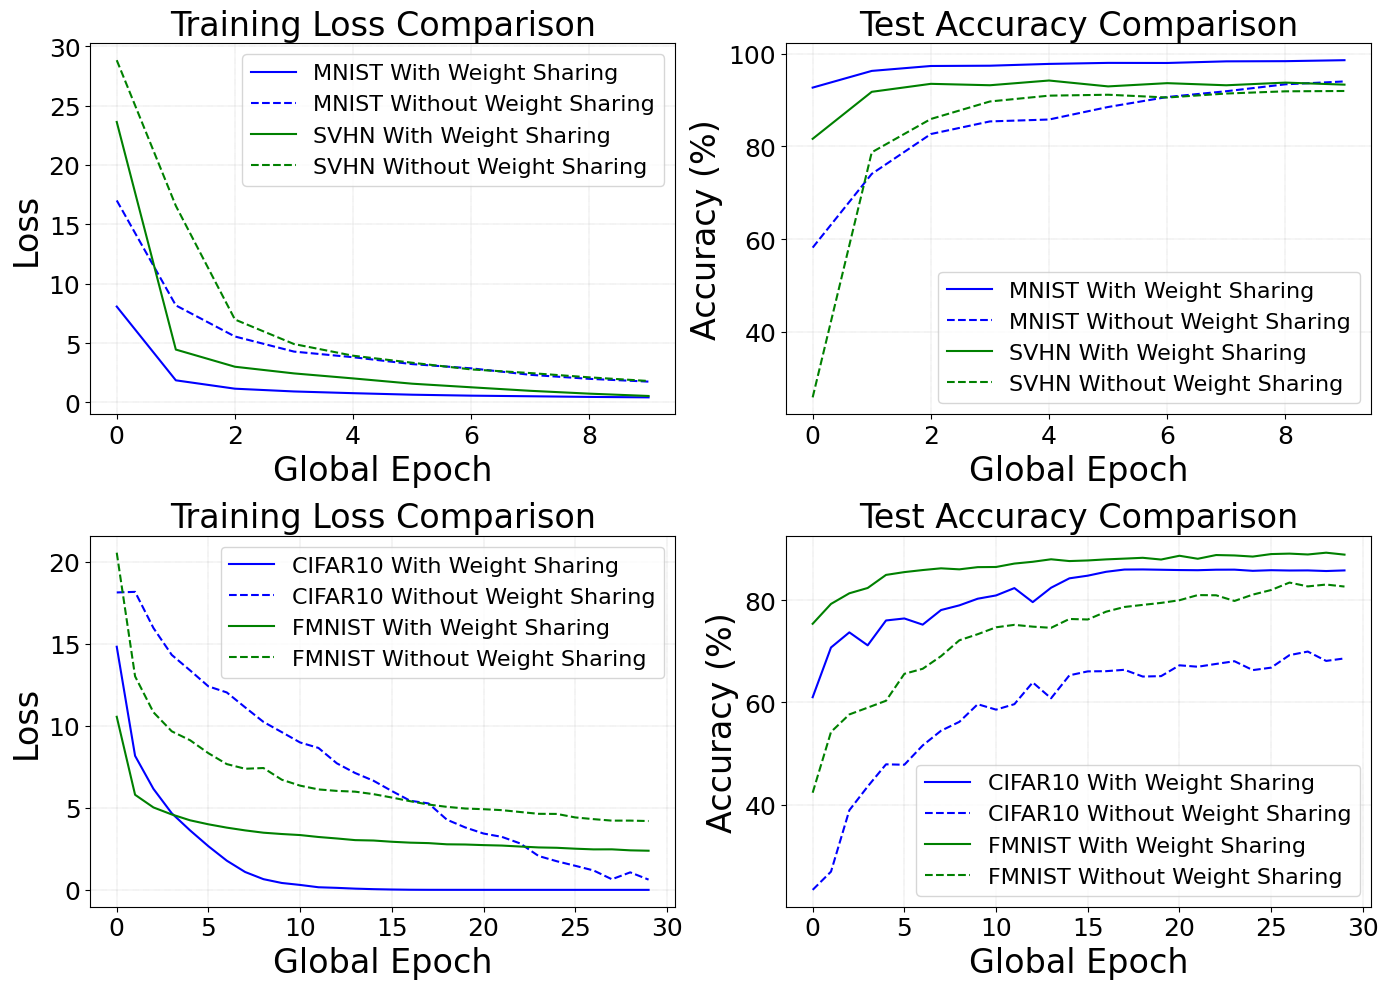

In [11]:
dataset1 = 'mnist'
dataset2 = 'svhn'
dataset3 = 'cifar10'
dataset4 = 'f_mnist'


# 读取第一个数据集的loss和准确率数据
losses_with_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-loss1.npy')
test_accuracies_with_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-acc1.npy')
losses_no_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-loss2.npy')
test_accuracies_no_sharing_1 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset1}-acc2.npy')

# 读取第二个数据集的loss和准确率数据
losses_with_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-loss1.npy')
test_accuracies_with_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-acc1.npy')
losses_no_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-loss2.npy')
test_accuracies_no_sharing_2 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset2}-acc2.npy')

# dataset3
losses_with_sharing_3 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset3}-loss1.npy')
test_accuracies_with_sharing_3 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset3}-acc1.npy')
losses_no_sharing_3 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset3}-loss2.npy')
test_accuracies_no_sharing_3 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset3}-acc2.npy')


# dataset4
losses_with_sharing_4 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset4}-loss1.npy')
test_accuracies_with_sharing_4 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset4}-acc1.npy')
losses_no_sharing_4 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset4}-loss2.npy')
test_accuracies_no_sharing_4 = np.load(f'D:\\Program\\MyCode\\Round_robin_SL\\Round-Robin\\{dataset4}-acc2.npy')


# 创建一个figure和两个子图
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# 绘制loss对比曲线
axs[0,0].plot(losses_with_sharing_1, label=f'MNIST With Weight Sharing', color='blue', linestyle='-')
axs[0,0].plot(losses_no_sharing_1, label=f'MNIST Without Weight Sharing', color='blue', linestyle='--')
axs[0,0].plot(losses_with_sharing_2, label=f'SVHN With Weight Sharing', color='green', linestyle='-')
axs[0,0].plot(losses_no_sharing_2, label=f'SVHN Without Weight Sharing', color='green', linestyle='--')
axs[0,0].set_xlabel('Global Epoch', fontsize=24)
axs[0,0].set_ylabel('Loss', fontsize=24)
axs[0,0].set_title('Training Loss Comparison', fontsize=24)
axs[0,0].legend(fontsize=16)
axs[0,0].grid(True, linestyle=':', linewidth=0.3, color='gray')


# 绘制测试准确率对比曲线
axs[0,1].plot(test_accuracies_with_sharing_1, label=f'MNIST With Weight Sharing', color='blue', linestyle='-')
axs[0,1].plot(test_accuracies_no_sharing_1, label=f'MNIST Without Weight Sharing', color='blue', linestyle='--')
axs[0,1].plot(test_accuracies_with_sharing_2, label=f'SVHN With Weight Sharing', color='green', linestyle='-')
axs[0,1].plot(test_accuracies_no_sharing_2, label=f'SVHN Without Weight Sharing', color='green', linestyle='--')
axs[0,1].set_xlabel('Global Epoch', fontsize=24)
axs[0,1].set_ylabel('Accuracy (%)', fontsize=24)
axs[0,1].set_title('Test Accuracy Comparison', fontsize=24)
axs[0,1].legend(fontsize=16)
axs[0,1].grid(True, linestyle=':', linewidth=0.3, color='gray')


axs[1,0].plot(losses_with_sharing_3, label=f'CIFAR10 With Weight Sharing', color='blue', linestyle='-')
axs[1,0].plot(losses_no_sharing_3, label=f'CIFAR10 Without Weight Sharing', color='blue', linestyle='--')
axs[1,0].plot(losses_with_sharing_4, label=f'FMNIST With Weight Sharing', color='green', linestyle='-')
axs[1,0].plot(losses_no_sharing_4, label=f'FMNIST Without Weight Sharing', color='green', linestyle='--')
axs[1,0].set_xlabel('Global Epoch', fontsize=24)
axs[1,0].set_ylabel('Loss', fontsize=24)
axs[1,0].set_title('Training Loss Comparison', fontsize=24)
axs[1,0].legend(fontsize=16)
axs[1,0].grid(True, linestyle=':', linewidth=0.3, color='gray')


axs[1,1].plot(test_accuracies_with_sharing_3, label=f'CIFAR10 With Weight Sharing', color='blue', linestyle='-')
axs[1,1].plot(test_accuracies_no_sharing_3, label=f'CIFAR10 Without Weight Sharing', color='blue', linestyle='--')
axs[1,1].plot(test_accuracies_with_sharing_4, label=f'FMNIST With Weight Sharing', color='green', linestyle='-')
axs[1,1].plot(test_accuracies_no_sharing_4, label=f'FMNIST Without Weight Sharing', color='green', linestyle='--')
axs[1,1].set_xlabel('Global Epoch', fontsize=24)
axs[1,1].set_ylabel('Accuracy (%)', fontsize=24)
axs[1,1].set_title('Test Accuracy Comparison', fontsize=24)
axs[1,1].legend(fontsize=16)
axs[1,1].grid(True, linestyle=':', linewidth=0.3, color='gray')


for row in axs:
    for ax in row:
        ax.tick_params(axis='both', which='major', labelsize=18)

# 显示图表
plt.tight_layout()
plt.show()